# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [2]:
# Create the spark session and load the dataframe
spark = SparkSession \
    .builder \
    .appName("Churn Analysis") \
    .getOrCreate()

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Create a view, in order to leverage the SQL syntax where applicable
df.createOrReplaceTempView('logs')

In [4]:
# Visualize the presence of potential null values in critical columns
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [5]:
# Explore missing values in firstName column
df.where(col('firstName').isNull()).show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [6]:
# Explore missing values in the artist column
df.where(col('artist').isNull()).show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [7]:
# Filter out logged out users
df = df.where(col('auth') != 'Logged Out')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
# Start by visualizing the variables available
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# Visualize all the events and their associated counts
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10118|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   509|
| Submit Registration|     5|
|            Settings|  1514|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1477|
|             Upgrade|   499|
|               Error|   253|
+--------------------+------+
only showing top 20 rows



In [10]:
# We see how many unique users are present in this dataset
spark.sql('SELECT COUNT(DISTINCT userId) AS nb_users FROM logs').show()

+--------+
|nb_users|
+--------+
|     226|
+--------+



In [11]:
# Create a dataset with all user ID's and a label which specifies whether that individual churned or not

# First a dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Then the other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two, shuffling the rows
churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Check that we have the right number of users
churn_df.count()

226

In [12]:
churn.show(2)

+------+-----+
|userId|churn|
+------+-----+
|100005|    1|
|300007|    1|
+------+-----+
only showing top 2 rows



In [13]:
# visualize the distribution of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,174
1,1,52


In [14]:
# Create a dataset with all user ID's and a label which specifies whether that individual downgraded or not
# First a dataset with users who churned
downgraded = spark.sql('SELECT DISTINCT userId, 1 as downgraded FROM logs WHERE Page = "Submit Downgrade"')

# Then the other users
no_downgraded = spark.sql('SELECT DISTINCT userId, 0 as downgraded FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Submit Downgrade")')

# Create a dataframe from the union of the two, shuffling the rows
downgraded_df = downgraded.union(no_downgraded)
downgraded_df.createOrReplaceTempView('downgraded')
downgraded_df = spark.sql('SELECT * FROM downgraded ORDER BY RAND()')
downgraded_df.createOrReplaceTempView('downgraded')

# Check that we have the right number of users
downgraded_df.count()

226

In [15]:
# visualize the distribution of users between churning or not
downgraded_pd_df = downgraded_df.toPandas()
downgraded_pd_df.groupby('downgraded', as_index=False).count()

,downgraded,userId
0,0,177
1,1,49


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [16]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(churn_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['churn', 'level']).count().show(5)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43430|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



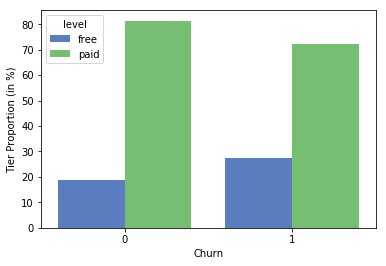

In [17]:
# Build a data visualization: a grouped bar chart of proportions
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df,
                palette="muted")
g.set(xlabel='Churn', ylabel="Tier Proportion (in %)")
plt.show();

In [18]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(downgraded_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['downgraded', 'level']).count().show(5)

+----------+-----+------+
|downgraded|level| count|
+----------+-----+------+
|         0| free| 31303|
|         0| paid|140296|
|         1| paid| 82137|
|         1| free| 24515|
+----------+-----+------+



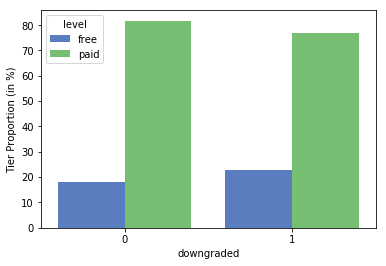

In [19]:
# Build a data visualization: a grouped bar chart of proportions
level_df = joined_df.groupBy(['downgraded', 'level']).count().toPandas()
downgrade_sum = level_df.groupby('downgraded', as_index=False).sum()
level_df['proportion'] = (level_df.join(downgrade_sum, on = 'downgraded', lsuffix='_1')['count_1']/level_df.join(downgrade_sum, on = 'downgraded', lsuffix='_1')['count'])*100

g = sns.barplot(x="downgraded", y="proportion", hue="level", data=level_df,
                palette="muted")
g.set(xlabel='downgraded', ylabel="Tier Proportion (in %)")
plt.show();

In [20]:
##DaysSinceRegistration
days_active = udf(lambda x,y: float((x-y)/(86400000.0)), FloatType())
df = df.withColumn("DaysSinceRegistration", days_active("ts", "registration"))
df.show(5)        

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|DaysSinceRegistration|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|            2.0689237|
|Five Iron Frenzy|Logged In|    Micah|     M|   

In [21]:
def fe_UserTimeBin(df, days):
    user_timebin = udf(lambda x: int(x/days), IntegerType())
    df = df.withColumn("UserTimeBin", user_timebin("DaysSinceRegistration"))
    return df

In [22]:
df = fe_UserTimeBin(df, 14)
df.createOrReplaceTempView("logs")
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------------------+-----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|DaysSinceRegistration|UserTimeBin|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------------------+-----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|            2.0689237|          0|


In [23]:
churned_user_ids = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()
df = df.withColumn('churn', when(col("userId").isin(churned_user_ids), 1).otherwise(0))

In [24]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-----------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|DaysSinceRegistration|UserTimeBin|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-----------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|            2.0689237|          0|    0|
+--------------+---------+---------+------+-----

In [25]:
downgraded_user_ids = df.filter(df.page == 'Submit Downgrade')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()
df = df.withColumn('downgrade', when(col("userId").isin(downgraded_user_ids), 1).otherwise(0))

In [26]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-----------+-----+---------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|DaysSinceRegistration|UserTimeBin|churn|downgrade|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-----------+-----+---------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|            2.0689237|          0|    0|        1|
+-------

In [27]:
# SQL method
df_auth = spark.sql("SELECT auth, COUNT(DISTINCT userId) as unique_user_count\
                     FROM logs\
                     WHERE userId IS NOT NULL AND userID != ''\
                     GROUP BY auth\
                     ORDER BY unique_user_count DESC")

df_auth.show()

n_users_registered = df_auth.filter(col('auth') == 'Logged In')\
                             .select('unique_user_count').first()[0]
n_users_left = df_auth.filter(col('auth') == 'Cancelled')\
                             .select('unique_user_count').first()[0]

print('The number of users registered: {} and the number of users left: {} with a churn ratio of: {}'\
                             .format(n_users_registered,n_users_left,round((n_users_left/n_users_registered),2)))

+---------+-----------------+
|     auth|unique_user_count|
+---------+-----------------+
|Logged In|              225|
|Cancelled|               52|
+---------+-----------------+

The number of users registered: 225 and the number of users left: 52 with a churn ratio of: 0.23


Here the above split suggests us that number of active users are 225 while the ones who have cancelled the registrations are 52. It means the churn ratio is at 23%. However it is tricky to consider just this information as churn as there are other factors which could also influence churn and that as well needs to be looked in. 

In [28]:
# Let's find the average number of songs played by churned and unchurned user.
df_songs_count = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .count()

df_songs_unique_users = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .agg(countDistinct(col('userId')))

avg_num_songs_played = df_songs_unique_users\
                .join(df_songs_count, df_songs_count.churn == df_songs_unique_users.churn)\
                .drop(df_songs_count.churn)

avg_num_songs_played = avg_num_songs_played\
                .withColumn('AvgNumberofSongs', \
                avg_num_songs_played['count']/avg_num_songs_played['count(DISTINCT userId)'])


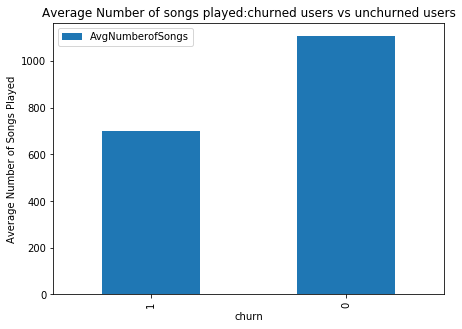

In [29]:
df_plt = avg_num_songs_played.select(['churn', 'AvgNumberofSongs']).toPandas().set_index('churn')
df_plt.plot(kind = 'bar', figsize = (7, 5), title = 'Average Number of songs played:churned users vs unchurned users');
plt.ylabel('Average Number of Songs Played');

In [30]:
# Average number of times each page is vistied: churned vs unchurned users.
df_page_churn_count = df.groupby(['churn','page']).agg({'page':'count'})

avg_num_page_visit = df_page_churn_count\
                .join(df_songs_unique_users, df_songs_unique_users.churn == df_page_churn_count.churn)\
                .drop(df_songs_unique_users.churn)

avg_num_page_visit = avg_num_page_visit\
                .withColumn('AvgNumberofPageVisit', \
                            avg_num_page_visit['count(page)']/avg_num_page_visit['count(DISTINCT userId)'])

In [31]:
# Exclding "NextSong" page as it dominates every other page, moreover NextSong has been shown seperately in the plot
# above.
avg_num_page_visit = avg_num_page_visit.filter(col('page') != 'NextSong')
avg_num_page_visit = avg_num_page_visit.toPandas()

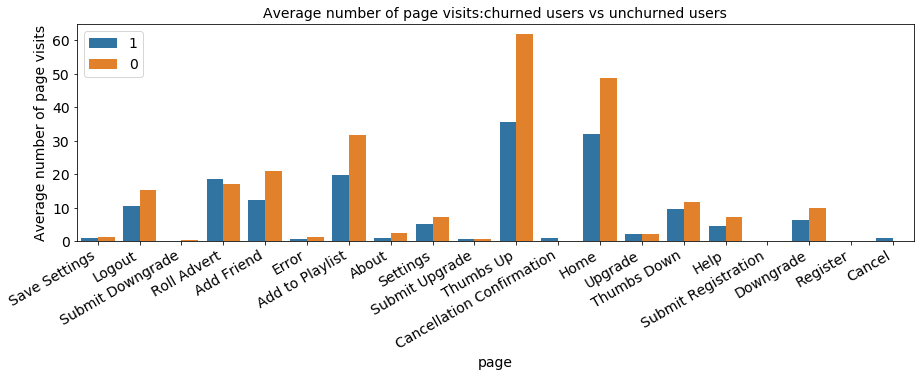

In [32]:
# Plotting average number of times each page is visted: churned vs unchurned users.
fig = plt.figure(figsize=(15, 4))
sns.barplot(x="page",y="AvgNumberofPageVisit", hue="churn", data=avg_num_page_visit, hue_order=[1, 0]);
plt.xticks(rotation=90, fontsize=14);
plt.yticks(fontsize=14)
plt.xlabel("page", fontsize=14)
plt.ylabel("Average number of page visits", fontsize=14)
plt.title("Average number of page visits:churned users vs unchurned users", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

In [33]:
# Let's find the average number of songs played by churned and unchurned user.
df_songs_count = df.filter(col('page')=='NextSong')\
                                .groupby(col('downgrade'))\
                                .count()

df_songs_unique_users = df.filter(col('page')=='NextSong')\
                                .groupby(col('downgrade'))\
                                .agg(countDistinct(col('userId')))

avg_num_songs_played = df_songs_unique_users\
                .join(df_songs_count, df_songs_count.downgrade == df_songs_unique_users.downgrade)\
                .drop(df_songs_count.downgrade)

avg_num_songs_played = avg_num_songs_played\
                .withColumn('AvgNumberofSongs', \
                avg_num_songs_played['count']/avg_num_songs_played['count(DISTINCT userId)'])


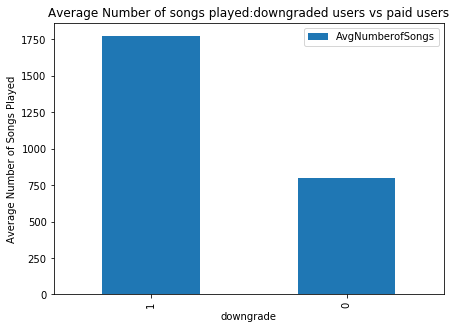

In [34]:
df_plt = avg_num_songs_played.select(['downgrade', 'AvgNumberofSongs']).toPandas().set_index('downgrade')
df_plt.plot(kind = 'bar', figsize = (7, 5), title = 'Average Number of songs played:downgraded users vs paid users');
plt.ylabel('Average Number of Songs Played');

In [35]:
# Average number of times each page is vistied: churned vs unchurned users.
df_page_churn_count = df.groupby(['downgrade','page']).agg({'page':'count'})

avg_num_page_visit = df_page_churn_count\
                .join(df_songs_unique_users, df_songs_unique_users.downgrade == df_page_churn_count.downgrade)\
                .drop(df_songs_unique_users.downgrade)

avg_num_page_visit = avg_num_page_visit\
                .withColumn('AvgNumberofPageVisit', \
                            avg_num_page_visit['count(page)']/avg_num_page_visit['count(DISTINCT userId)'])

In [36]:
# Exclding "NextSong" page as it dominates every other page, moreover NextSong has been shown seperately in the plot
# above.
avg_num_page_visit = avg_num_page_visit.filter(col('page') != 'NextSong')
avg_num_page_visit = avg_num_page_visit.toPandas()

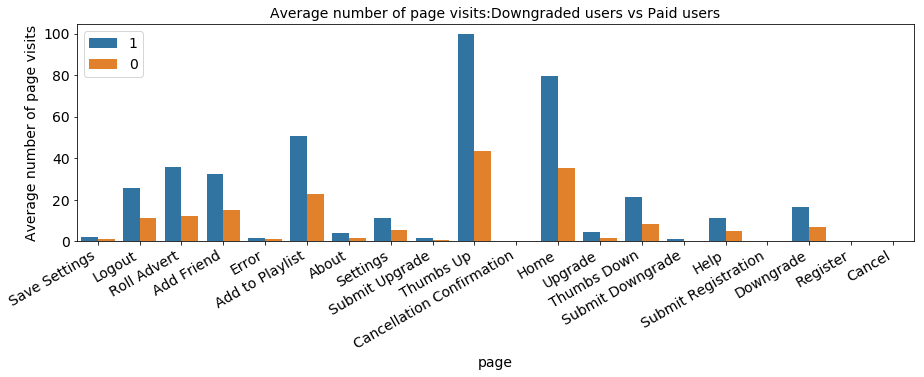

In [37]:
# Plotting average number of times each page is visted: churned vs unchurned users.
fig = plt.figure(figsize=(15, 4))
sns.barplot(x="page",y="AvgNumberofPageVisit", hue="downgrade", data=avg_num_page_visit, hue_order=[1, 0]);
plt.xticks(rotation=90, fontsize=14);
plt.yticks(fontsize=14)
plt.xlabel("page", fontsize=14)
plt.ylabel("Average number of page visits", fontsize=14)
plt.title("Average number of page visits:Downgraded users vs Paid users", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

Above visuals, clearly reveals us what features influence churn. Attributes which causes the users to downgrade, eventually results in Churn.  

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.